<a href="https://colab.research.google.com/github/AutoViML/lazytransform/blob/main/Featurewiz_LazyTransform_Demo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is a LazyTransformer demo along with FeatureWiz

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
np.random.seed(0)

In [2]:
#####   Use this for debugging/development version ############
import featurewiz as FW

Imported featurewiz. Version = 0.1.22. nrows=None uses all rows. Set nrows=1000 to randomly sample 1000 rows.
outputs = featurewiz(dataname, target, corr_limit=0.70, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']
                                


In [3]:
from lazytransform import LazyTransformer

Imported LazyTransformer version:0.26. Call by using:
    lazy = LazyTransformer(model=False, encoders='auto', scalers=None, 
        date_to_string=False, transform_target=False, imbalanced=False)
    ### if you are not using a model in pipeline, you must use fit and transform ##
    X_trainm, y_trainm = lazy.fit_transform(X_train, y_train)
    X_testm = lazy.transform(X_test)
    ### If using a model in pipeline, use fit and predict only ###
    lazy.fit(X_train, y_train)
    lazy.predict(X_test)



In [4]:
from sklearn.datasets import load_boston, load_diabetes
#bunch = load_boston()
bunch = load_diabetes()
y = pd.DataFrame(bunch.target, columns=['target'])
X = pd.DataFrame(bunch.data, columns=bunch.feature_names)
print(X.shape, y.shape)
X.head()

(442, 10) (442, 1)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [5]:
target = 'target'
modeltype = 'Regression'

In [6]:
encoders = 'auto'
scalers = 'std'

# LightGBM is used here. But you can use any sklearn model.

In [7]:
import lightgbm as lgbm
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
if modeltype == 'Regression':
    lgb = lgbm.LGBMRegressor(device="cpu")
    if isinstance(target, list):
        if len(target) > 1:
            lgb = MultiOutputRegressor(lgb)
else:
    lgb = lgbm.LGBMClassifier(device="cpu")
    if isinstance(target, list):
        if len(target) > 1:
            lgb = MultiOutputClassifier(lgb)

In [8]:
import featurewiz as FW

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=99)
print(X_train.shape, X_test.shape)

(353, 10) (89, 10)


In [10]:
y_train.head()

,target
225,208.0
85,141.0
28,131.0
230,220.0
435,64.0


# Baseline model with all features - let's see performance

In [11]:
print('all features = %d' %X_train.shape[1])

all features = 10


In [12]:
sim = LazyTransformer(model=lgb, encoders='auto',scalers=scalers, imbalanced=False)
sim

In [13]:
### If using a model in pipeline, use fit and predict only ###
sim.fit(X_train, y_train)

#### Single_Label Regression problem ####
Shape of dataset: (353, 10). Now we classify variables into different types...
    no date time variables detected in this dataset
    Time taken to define data pipeline = 1 second(s)
    Data Pipeline is saved as: LazyTransformer_pipeline.pkl in current working directory.
model pipeline fitted with LGBMRegressor model


In [14]:
### If using a model in pipeline, use fit and predict only ###
predictions = sim.predict(X_test)

In [15]:
import sklearn
if modeltype == 'Regression':
    print('R-squared = %0.0f%%' %(100*sklearn.metrics.r2_score(y_test, predictions)))
    print('RMSE = %0.2f' %np.sqrt(sklearn.metrics.mean_squared_error(y_test, predictions)))
else:
    print(sklearn.metrics.classification_report(y_test, predictions))

R-squared = 31%
RMSE = 63.43


# Let's compare it with a model with select features from featurewiz

In [16]:
sim = LazyTransformer(model=lgb, encoders=encoders,scalers=scalers, imbalanced=False)
sim

In [17]:
X_train_trans, y_train_trans = sim.fit_transform(X_train, y_train)
X_train_trans.shape

#### Single_Label Regression problem ####
Shape of dataset: (353, 10). Now we classify variables into different types...
    no date time variables detected in this dataset
    Time taken to define data pipeline = 1 second(s)
    Data Pipeline is saved as: LazyTransformer_pipeline.pkl in current working directory.
model pipeline fitted with LGBMRegressor model
    Time taken to transform dataset = 1 second(s)


(353, 10)

In [18]:
X_test_trans = sim.transform(X_test)
X_test_trans.shape

    Time taken to transform dataset = 1 second(s)


(89, 10)

# If you have NLP vars, featurewiz will automatically drop them hence use lazytransform to create word vectors. Hence it is better to run featurewiz first and then lazytransform even in NLP datasets.

############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
**INFO: featurewiz can now read feather formatted files. Loading train data...
    Shape of your Data Set loaded: (353, 11)
     Loaded. Shape = (353, 11)
No special characters in dataset predictors. Now checking target variable...
No test data filename given...
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    10 Predictors classified...
        No variables removed since no ID or low-information variables found in dat

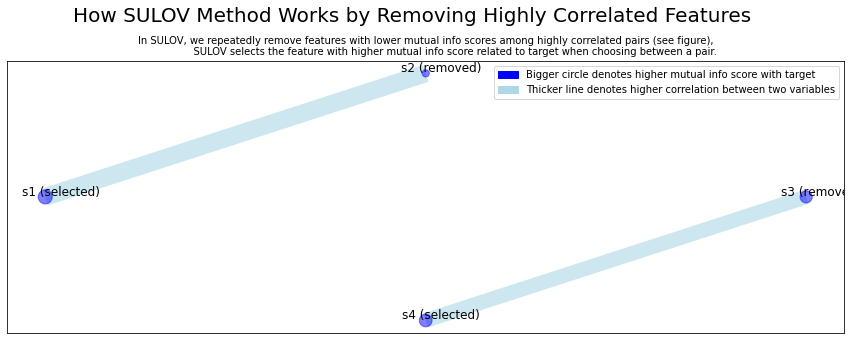

Time taken for SULOV method = 1 seconds
    Adding 0 categorical variables to reduced numeric variables  of 8
Final list of selected vars after SULOV = 8
############## F E A T U R E   S E L E C T I O N  ####################
    using regular XGBoost
Train and Test loaded into Dask dataframes successfully after feature_engg completed
Current number of predictors = 8 
    XGBoost version: 1.5.1
Number of booster rounds = 100
        using 8 variables...
            Time taken for regular XGBoost feature selection = 0 seconds
        using 6 variables...
            Time taken for regular XGBoost feature selection = 1 seconds
        using 4 variables...
            Time taken for regular XGBoost feature selection = 1 seconds
        using 2 variables...
            Time taken for regular XGBoost feature selection = 1 seconds


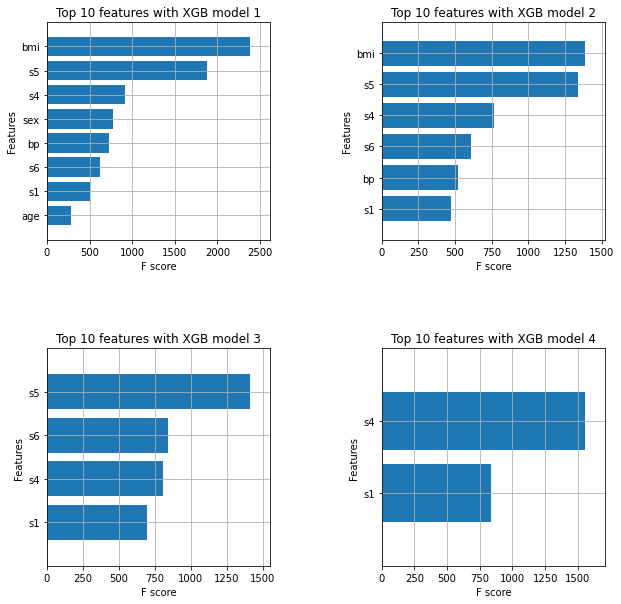

            Total time taken for XGBoost feature selection = 2 seconds
No ID variables [] are selected since they are not considered important for modeling
Selected 8 important features:
['bmi', 's5', 's4', 'sex', 'bp', 's6', 's1', 'age']
    Time taken = 2 seconds
    Reverted column names to original names given in train dataset
Returning list of 8 important features and a dataframe.
    Time taken to create entire pipeline = 2 second(s)


In [19]:
features = FW.FeatureWiz(corr_limit=0.70, feature_engg='', category_encoders='', dask_xgboost_flag=False, nrows=None, verbose=2)
X_train_selected = features.fit_transform(X_train_trans, y_train_trans)
X_test_selected = features.transform(X_test_trans)

In [20]:
select = features.features  ### provides the list of selected features ###
print('Select features = %d' %len(select))
print(select)

Select features = 8
['bmi', 's5', 's4', 'sex', 'bp', 's6', 's1', 'age']


In [21]:
sim = LazyTransformer(model=lgb, encoders=encoders,scalers=scalers, imbalanced=False)
sim

In [22]:
### If using a model in pipeline, use fit and predict only ###
sim.fit(X_train_selected, y_train)

#### Single_Label Regression problem ####
Shape of dataset: (353, 8). Now we classify variables into different types...
    no date time variables detected in this dataset
    Time taken to define data pipeline = 1 second(s)
    Data Pipeline is saved as: LazyTransformer_pipeline.pkl in current working directory.
model pipeline fitted with LGBMRegressor model


In [23]:
### If using a model in pipeline, use fit and predict only ###
predictions = sim.predict(X_test_selected)
predictions[:3]

array([105.25359909, 210.90495523,  90.78370909])

In [24]:
import sklearn
if modeltype == 'Regression':
    print('R-squared = %0.0f%%' %(100*sklearn.metrics.r2_score(y_test, predictions)))
    print('RMSE = %0.2f' %np.sqrt(sklearn.metrics.mean_squared_error(y_test, predictions)))
else:
    #dicto = {0:'f',1:'t'}
    dicto = {0:0,1:1}
    print(sklearn.metrics.classification_report(y_test, pd.Series(predictions).map(dicto)))

R-squared = 35%
RMSE = 61.84


# So feature selection works better in this case than using all features. You can view the lazytransform pipeline here

In [25]:
from sklearn import set_config
set_config(display="diagram")
sim.xformer
# If you have a model in the pipeline, do:
sim.modelformer

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('scaler_pipeline',
                                  Pipeline(steps=[('complete_pipeline',
                                                   ColumnTransformer(transformers=[('simpleimputer',
                                                                                    SimpleImputer(fill_value=-99,
                                                                                                  strategy='constant'),
                                                                                    ['bmi',
                                                                                     's5',
                                                                                     's4',
                                                                                     'sex',
                                                                                     'bp',
                                                                                     's6',
                                                                                     's1',
                                                                                     'age'])])),
                                                  ('scaler',
                                                   StandardScaler())])),
                                 ('nlp_pipeline',
                                  Pipeline(steps=[('NLP',
                                                   FunctionTransformer(func=<function create_column_names_onehot at 0x0000021261D08820>,
                                                                       kw_args={'catvars': [],
                                                                                'colsize_dict': {},
                                                                                'datesize_dict': {},
                                                                                'datevars': [],
                                                                                'discretevars': [],
                                                                                'nlpvars': [],
                                                                                'numvars': ['bmi',
                                                                                            's5',
                                                                                            's4',
                                                                                            'sex',
                                                                                            'bp',
                                                                                            's6',
                                                                                            's1',
                                                                                            'age'],
                                                                                'onehot_dict': {}}))]))])),
                ('model', LGBMRegressor(device='cpu'))])

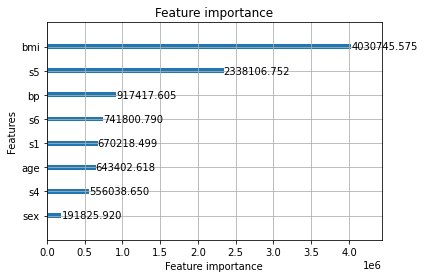

In [26]:
lazy.plot_importance()